# Live Human Pose Estimation with OpenVINO™

This notebook demonstrates live pose estimation with OpenVINO, using the OpenPose [human-pose-estimation-0001](https://github.com/openvinotoolkit/open_model_zoo/tree/master/models/intel/human-pose-estimation-0001) model from [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/). Final part of this notebook shows live inference results from a webcam. Additionally, you can also upload a video file.

> **NOTE**: To use a webcam, you must run this Jupyter notebook on a computer with a webcam. If you run on a server, the webcam will not work. However, you can still do inference on a video in the final step.
#### Table of contents:
- [Imports](#Imports)
- [The model](#The-model)
    - [Download the model](#Download-the-model)
    - [Load the model](#Load-the-model)
- [Processing](#Processing)
    - [OpenPose Decoder](#OpenPose-Decoder)
    - [Process Results](#Process-Results)
    - [Draw Pose Overlays](#Draw-Pose-Overlays)
    - [Main Processing Function](#Main-Processing-Function)
- [Run](#Run)
    - [Run Live Pose Estimation](#Run-Live-Pose-Estimation)


In [2]:
%pip install -q "openvino>=2023.1.0"

import urllib.request

urllib.request.urlretrieve(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/main/notebooks/utils/notebook_utils.py",
    filename="notebook_utils.py",
) 


Note: you may need to restart the kernel to use updated packages.


('notebook_utils.py', <http.client.HTTPMessage at 0x248a1cb3250>)

## Imports
[back to top ⬆️](#Table-of-contents:)


In [3]:
import collections
import sys
import time
from pathlib import Path

import cv2
import numpy as np
from IPython import display
from numpy.lib.stride_tricks import as_strided
import openvino as ov

from decoder import OpenPoseDecoder

sys.path.append("../utils")
import notebook_utils as utils

## The model
[back to top ⬆️](#Table-of-contents:)

### Download the model
[back to top ⬆️](#Table-of-contents:)

Use the `download_file`, a function from the `notebook_utils` file. It automatically creates a directory structure and downloads the selected model.

If you want to download another model, replace the name of the model and precision in the code below. 

> **NOTE**: This may require a different pose decoder.

In [4]:
# A directory where the model will be downloaded.
base_model_dir = Path("model")

# The name of the model from Open Model Zoo.
model_name = "human-pose-estimation-0001"
# Selected precision (FP32, FP16, FP16-INT8).
precision = "FP16-INT8"

model_path = base_model_dir / "intel" / model_name / precision / f"{model_name}.xml"

if not model_path.exists():
    model_url_dir = f"https://storage.openvinotoolkit.org/repositories/open_model_zoo/2022.1/models_bin/3/{model_name}/{precision}/"
    utils.download_file(model_url_dir + model_name + '.xml', model_path.name, model_path.parent)
    utils.download_file(model_url_dir + model_name + '.bin', model_path.with_suffix('.bin').name, model_path.parent)

model\intel\human-pose-estimation-0001\FP16-INT8\human-pose-estimation-0001.xml:   0%|          | 0.00/474k [0…

model\intel\human-pose-estimation-0001\FP16-INT8\human-pose-estimation-0001.bin:   0%|          | 0.00/4.03M […

### Load the model
[back to top ⬆️](#Table-of-contents:)

Downloaded models are located in a fixed structure, which indicates a vendor, the name of the model and a precision.

Only a few lines of code are required to run the model. First, initialize OpenVINO Runtime. Then, read the network architecture and model weights from the `.bin` and `.xml` files to compile it for the desired device. Select device from dropdown list for running inference using OpenVINO.

In [5]:
import ipywidgets as widgets

core = ov.Core()

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=3, options=('CPU', 'GPU.0', 'GPU.1', 'AUTO'), value='AUTO')

In [6]:
# Initialize OpenVINO Runtime
core = ov.Core()
# Read the network from a file.
model = core.read_model(model_path)
# Let the AUTO device decide where to load the model (you can use CPU, GPU as well).
compiled_model = core.compile_model(model=model, device_name=device.value, config={"PERFORMANCE_HINT": "LATENCY"})

# Get the input and output names of nodes.
input_layer = compiled_model.input(0)
output_layers = compiled_model.outputs

# Get the input size.
height, width = list(input_layer.shape)[2:]

Input layer has the name of the input node and output layers contain names of output nodes of the network. In the case of OpenPose Model, there is 1 input and 2 outputs: PAFs and keypoints heatmap.

In [7]:
input_layer.any_name, [o.any_name for o in output_layers]

('data', ['Mconv7_stage2_L1', 'Mconv7_stage2_L2'])

## Processing
[back to top ⬆️](#Table-of-contents:)

### OpenPose Decoder
[back to top ⬆️](#Table-of-contents:)

To transform the raw results from the neural network into pose estimations, you need OpenPose Decoder. It is provided in the [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/blob/master/demos/common/python/openvino/model_zoo/model_api/models/open_pose.py) and compatible with the `human-pose-estimation-0001` model.

If you choose a model other than `human-pose-estimation-0001` you will need another decoder (for example, `AssociativeEmbeddingDecoder`), which is available in the [demos section](https://github.com/openvinotoolkit/open_model_zoo/blob/master/demos/common/python/openvino/model_zoo/model_api/models/hpe_associative_embedding.py) of Open Model Zoo.

In [8]:
decoder = OpenPoseDecoder()

### Process Results
[back to top ⬆️](#Table-of-contents:)

A bunch of useful functions to transform results into poses.

First, pool the heatmap. Since pooling is not available in numpy, use a simple method to do it directly with numpy. Then, use non-maximum suppression to get the keypoints from the heatmap. After that, decode poses by using the decoder. Since the input image is bigger than the network outputs, you need to multiply all pose coordinates by a scaling factor.

In [9]:
# 2D pooling in numpy (from: https://stackoverflow.com/a/54966908/1624463)
def pool2d(A, kernel_size, stride, padding, pool_mode="max"):
    """
    2D Pooling

    Parameters:
        A: input 2D array
        kernel_size: int, the size of the window
        stride: int, the stride of the window
        padding: int, implicit zero paddings on both sides of the input
        pool_mode: string, 'max' or 'avg'
    """
    # Padding
    A = np.pad(A, padding, mode="constant")

    # Window view of A
    output_shape = (
        (A.shape[0] - kernel_size) // stride + 1,
        (A.shape[1] - kernel_size) // stride + 1,
    )
    kernel_size = (kernel_size, kernel_size)
    A_w = as_strided(
        A,
        shape=output_shape + kernel_size,
        strides=(stride * A.strides[0], stride * A.strides[1]) + A.strides
    )
    A_w = A_w.reshape(-1, *kernel_size)

    # Return the result of pooling.
    if pool_mode == "max":
        return A_w.max(axis=(1, 2)).reshape(output_shape)
    elif pool_mode == "avg":
        return A_w.mean(axis=(1, 2)).reshape(output_shape)


# non maximum suppression
def heatmap_nms(heatmaps, pooled_heatmaps):
    return heatmaps * (heatmaps == pooled_heatmaps)


# Get poses from results.
def process_results(img, pafs, heatmaps):
    # This processing comes from
    # https://github.com/openvinotoolkit/open_model_zoo/blob/master/demos/common/python/models/open_pose.py
    pooled_heatmaps = np.array(
        [[pool2d(h, kernel_size=3, stride=1, padding=1, pool_mode="max") for h in heatmaps[0]]]
    )
    nms_heatmaps = heatmap_nms(heatmaps, pooled_heatmaps)

    # Decode poses.
    poses, scores = decoder(heatmaps, nms_heatmaps, pafs)
    output_shape = list(compiled_model.output(index=0).partial_shape)
    output_scale = img.shape[1] / output_shape[3].get_length(), img.shape[0] / output_shape[2].get_length()
    # Multiply coordinates by a scaling factor.
    poses[:, :, :2] *= output_scale
    return poses, scores

### Draw Pose Overlays
[back to top ⬆️](#Table-of-contents:)

Draw pose overlays on the image to visualize estimated poses. Joints are drawn as circles and limbs are drawn as lines. The code is based on the [Human Pose Estimation Demo](https://github.com/openvinotoolkit/open_model_zoo/tree/master/demos/human_pose_estimation_demo/python) from Open Model Zoo.

In [10]:
colors = ((255, 0, 0), (255, 0, 255), (170, 0, 255), (255, 0, 85), (255, 0, 170), (85, 255, 0),
          (255, 170, 0), (0, 255, 0), (255, 255, 0), (0, 255, 85), (170, 255, 0), (0, 85, 255),
          (0, 255, 170), (0, 0, 255), (0, 255, 255), (85, 0, 255), (0, 170, 255))

default_skeleton = ((15, 13), (13, 11), (16, 14), (14, 12), (11, 12), (5, 11), (6, 12), (5, 6), (5, 7),
                    (6, 8), (7, 9), (8, 10), (1, 2), (0, 1), (0, 2), (1, 3), (2, 4), (3, 5), (4, 6))


def draw_poses(img, poses, point_score_threshold, skeleton=default_skeleton):
    if poses.size == 0:
        return img

    img_limbs = np.copy(img)
    for pose in poses:
        points = pose[:, :2].astype(np.int32)
        points_scores = pose[:, 2]
        # Draw joints.
        for i, (p, v) in enumerate(zip(points, points_scores)):
            if v > point_score_threshold:
                cv2.circle(img, tuple(p), 1, colors[i], 2)
        # Draw limbs.
        for i, j in skeleton:
            if points_scores[i] > point_score_threshold and points_scores[j] > point_score_threshold:
                cv2.line(img_limbs, tuple(points[i]), tuple(points[j]), color=colors[j], thickness=4)
    cv2.addWeighted(img, 0.4, img_limbs, 0.6, 0, dst=img)
    return img

### Main Processing Function
[back to top ⬆️](#Table-of-contents:)

Run pose estimation on the specified source. Either a webcam or a video file.

In [11]:
# Main processing function to run pose estimation.
def run_pose_estimation(source=0, flip=False, use_popup=False, skip_first_frames=0):
    pafs_output_key = compiled_model.output("Mconv7_stage2_L1")
    heatmaps_output_key = compiled_model.output("Mconv7_stage2_L2")
    player = None
    try:
        # Create a video player to play with target fps.
        player = utils.VideoPlayer(source, flip=flip, fps=30, skip_first_frames=skip_first_frames)
        # Start capturing.
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(title, cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE)

        processing_times = collections.deque()

        while True:
            # Grab the frame.
            frame = player.next()
            if frame is None:
                print("Source ended")
                break
            # If the frame is larger than full HD, reduce size to improve the performance.
            scale = 1280 / max(frame.shape)
            if scale < 1:
                frame = cv2.resize(frame, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)

            # Resize the image and change dims to fit neural network input.
            # (see https://github.com/openvinotoolkit/open_model_zoo/tree/master/models/intel/human-pose-estimation-0001)
            input_img = cv2.resize(frame, (width, height), interpolation=cv2.INTER_AREA)
            # Create a batch of images (size = 1).
            input_img = input_img.transpose((2,0,1))[np.newaxis, ...]

            # Measure processing time.
            start_time = time.time()
            # Get results.
            results = compiled_model([input_img])
            stop_time = time.time()

            pafs = results[pafs_output_key]
            heatmaps = results[heatmaps_output_key]
            # Get poses from network results.
            poses, scores = process_results(frame, pafs, heatmaps)

            # Draw poses on a frame.
            frame = draw_poses(frame, poses, 0.1)

            processing_times.append(stop_time - start_time)
            # Use processing times from last 200 frames.
            if len(processing_times) > 200:
                processing_times.popleft()

            _, f_width = frame.shape[:2]
            # mean processing time [ms]
            processing_time = np.mean(processing_times) * 1000
            fps = 1000 / processing_time
            cv2.putText(frame, f"Inference time: {processing_time:.1f}ms ({fps:.1f} FPS)", (20, 40),
                        cv2.FONT_HERSHEY_COMPLEX, f_width / 1000, (0, 0, 255), 1, cv2.LINE_AA)

            # Use this workaround if there is flickering.
            if use_popup:
                cv2.imshow(title, frame)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Encode numpy array to jpg.
                _, encoded_img = cv2.imencode(".jpg", frame, params=[cv2.IMWRITE_JPEG_QUALITY, 90])
                # Create an IPython image.
                i = display.Image(data=encoded_img)
                # Display the image in this notebook.
                display.clear_output(wait=True)
                display.display(i)
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()

## Run
[back to top ⬆️](#Table-of-contents:)

### Run Live Pose Estimation
[back to top ⬆️](#Table-of-contents:)

Use a webcam as the video input. By default, the primary webcam is set with `source=0`. If you have multiple webcams, each one will be assigned a consecutive number starting at 0. Set `flip=True` when using a front-facing camera. Some web browsers, especially Mozilla Firefox, may cause flickering. If you experience flickering, set `use_popup=True`.

> **NOTE**: To use this notebook with a webcam, you need to run the notebook on a computer with a webcam. If you run the notebook on a server (for example, Binder), the webcam will not work. Popup mode may not work if you run this notebook on a remote computer (for example, Binder).

If you do not have a webcam, you can still run this demo with a video file. Any [format supported by OpenCV](https://docs.opencv.org/4.5.1/dd/d43/tutorial_py_video_display.html) will work. You can skip first `N` frames to fast forward video.

Run the pose estimation:

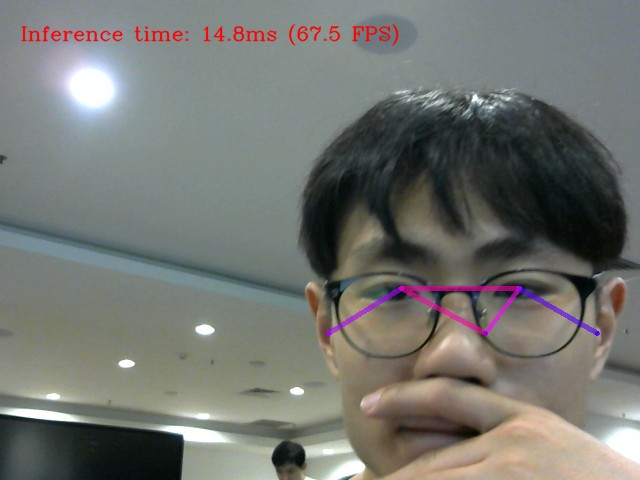

Interrupted
None


In [13]:
USE_WEBCAM = True
cam_id = 0
video_file = "https://github.com/intel-iot-devkit/sample-videos/blob/master/store-aisle-detection.mp4?raw=true"
source = cam_id if USE_WEBCAM else video_file

additional_options = {"skip_first_frames": 500} if not USE_WEBCAM else {}
run_pose_estimation(source=source, flip=isinstance(source, int), use_popup=False, **additional_options)